# Emotion Classification

# Load data and Pre-process/Data Cleaning

In [2]:
import pandas as pd
# import nltk
# nltk.download('punkt')

def convert_text_to_df(filename):
    
    # The dataset is in text format, so converting that to dataframe for easier manipulation
    with open(filename) as file:
        lines = file.readlines()
    
    file.close()   
    df = pd.DataFrame(columns = ['Sentence', 'Emotion'])

    for line in lines:
        x = line.split(';')
        df = df.append({'Sentence' : x[0], 'Emotion' : x[1].strip()}, ignore_index = True)
    
    return df

df_train = convert_text_to_df('train.txt')
df_test = convert_text_to_df('test.txt')
print(df_train.head())
print(df_test.head())

                                            Sentence  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
                                            Sentence  Emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness


# Steps performed :
1) Read text file and convert to dataframe object

2) During this conversion, we also need to split the string when we encounter semicolon(;) as this distinguish our class label and text input.

3) Observation: There is a \n (newline character at the end of the emotion label) 

4) Removed that using strip function.

5) Next, we will check for any missing or null value in the dataset.

6) Dropped rows with "Surprise"(5 after label encoding) as this class has very less number of rows comparative to other classes.

7) Since the label is categorical, we will have to convert that to numbers as machines only understand numerical values.


In [3]:
df_train.isnull().sum() #check missing value

Sentence    0
Emotion     0
dtype: int64

In [4]:
df_test.isnull().sum() #check missing value

Sentence    0
Emotion     0
dtype: int64

In [5]:
df_train['Emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

In [6]:
df_train.shape

(16000, 2)

In [7]:
df_test.shape

(2000, 2)

In [8]:
df_train = df_train[df_train['Emotion'] != 'surprise']
df_train['Emotion'].value_counts()

joy        5362
sadness    4666
anger      2159
fear       1937
love       1304
Name: Emotion, dtype: int64

In [9]:
df_test = df_test[df_test['Emotion'] != 'surprise']
df_test['Emotion'].value_counts()

joy        695
sadness    581
anger      275
fear       224
love       159
Name: Emotion, dtype: int64

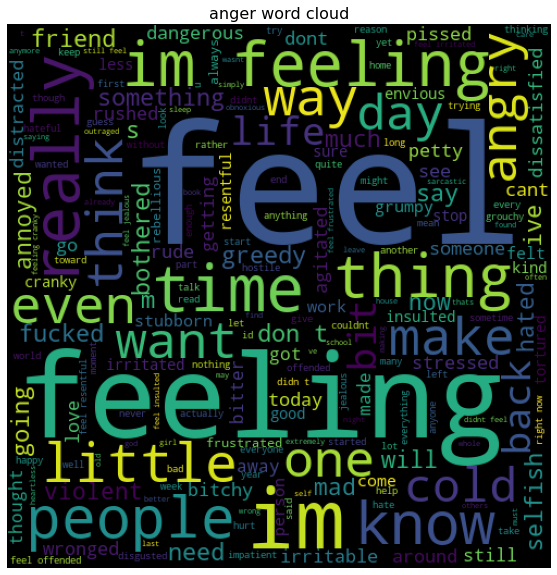

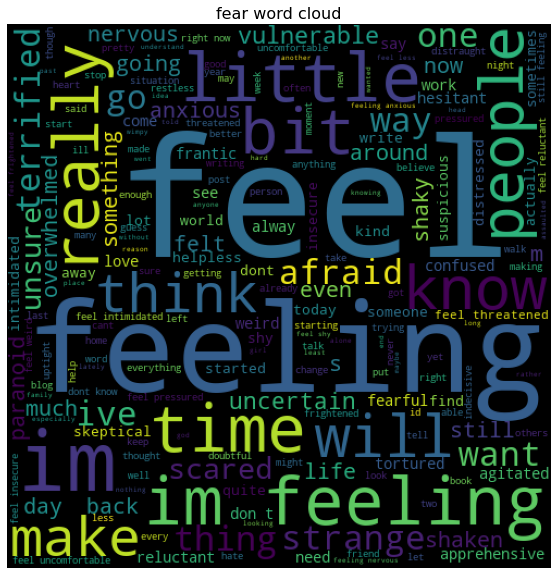

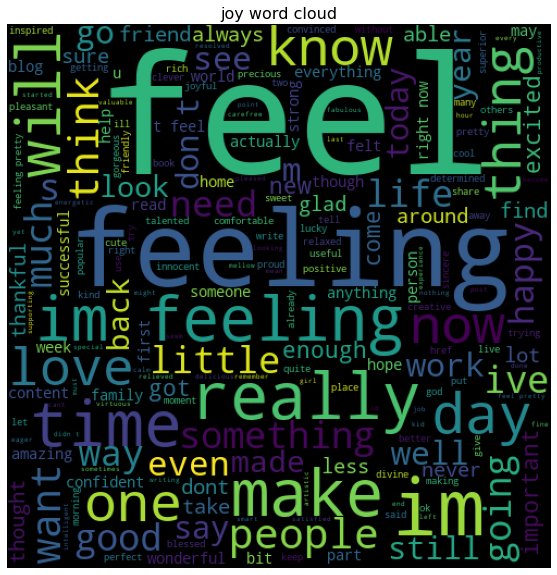

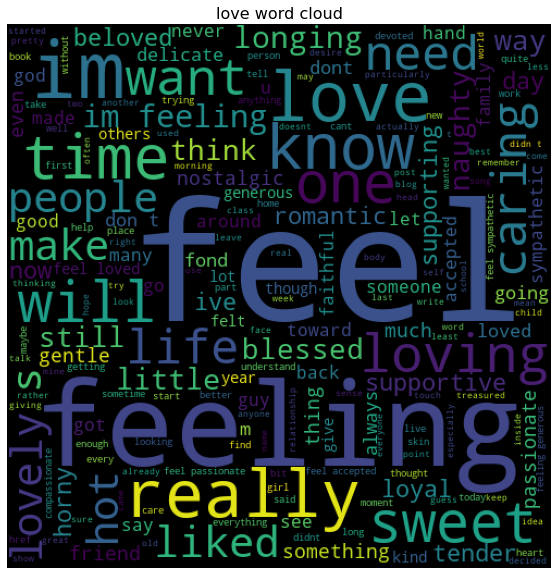

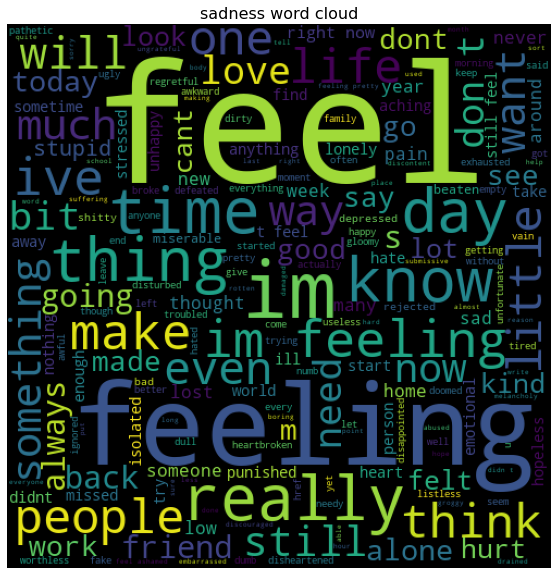

In [10]:
# Create a word cloud draw function
from matplotlib import pyplot as plt
from wordcloud import WordCloud

def word_cloud(wc, df):
    plt.figure(figsize=(10,10))
    plt.title(df+' word cloud', size=16)
    plt.imshow(wc)
    plt.axis('off')

emotion_label_list = ['anger', 'fear', 'joy', 'love', 'sadness']

for emotion in emotion_label_list:
    text_input = ' '.join([text for text in df_train.loc[df_train['Emotion'] == emotion,'Sentence']])
    wc = WordCloud(width=500, height=500).generate(text_input)
    word_cloud(wc, emotion)
    

In [11]:
# Added Histogram to see the word usage

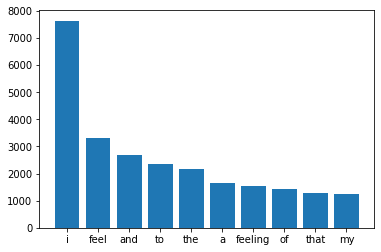

In [12]:
from collections import Counter

text_list = text_input.split()

word_data = Counter(text_list).most_common(10)

plt.bar(*zip(*word_data));

plt.show()

In [13]:
# We see that lot of the frequent words are filler words
# So we need to do some preprocessing beforehand

In [14]:
# Visualizing most frequent words in each label
# Excluded stop words and few filler words. More filler words need to be filtered out.

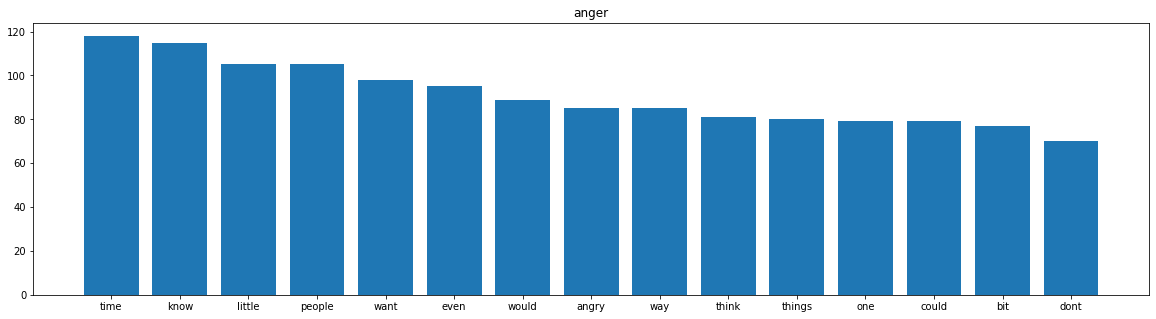

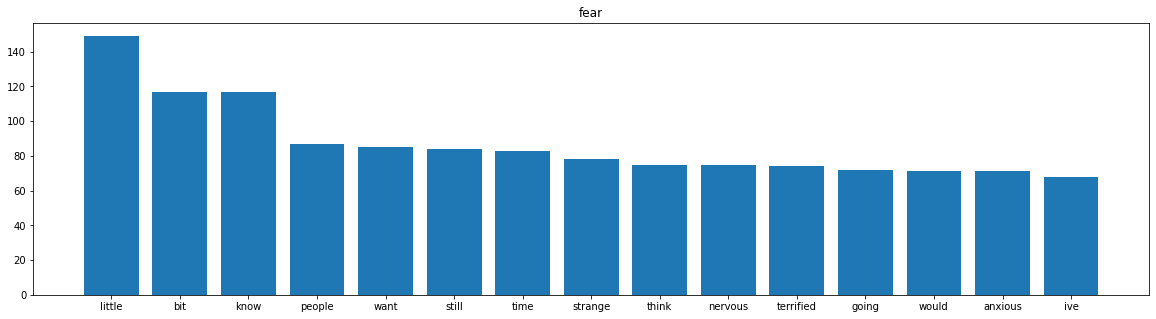

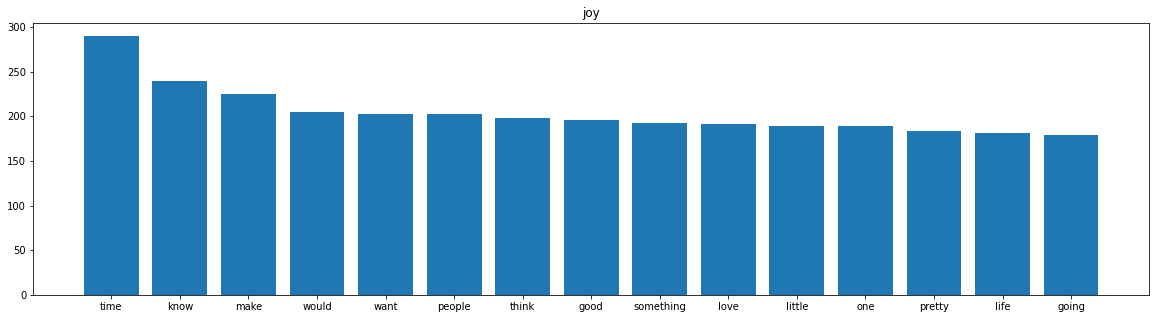

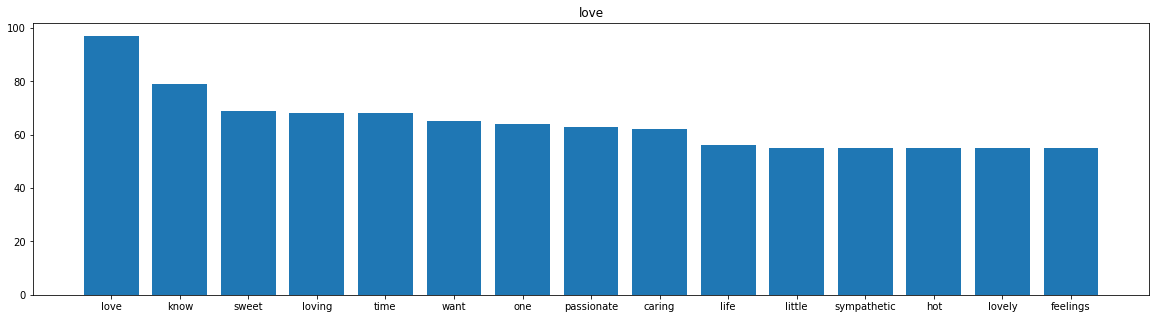

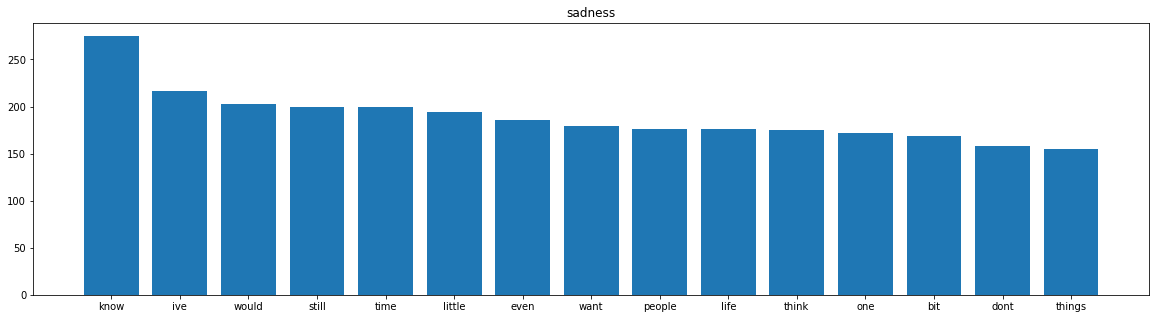

In [15]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

for emotion in emotion_label_list:
    text_input_em = (' '.join([text for text in df_train.loc[df_train['Emotion'] == emotion,'Sentence']]))
    stop_words = set(stopwords.words('english'))
    stop_words.add('feel'); stop_words.add('feeling');stop_words.add('like');stop_words.add('im');stop_words.add('really');stop_words.add('get')
    word_tokens = word_tokenize(text_input_em)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    frequency = Counter(filtered_sentence).most_common(15)
    plt.figure(figsize=(20, 5))
    plt.title(emotion)
    plt.bar(*zip(*frequency));
    plt.show()

In [16]:
# Data balancing technique and see if the model improves(keeping surprise class)

In [17]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df_train['Emotion']= label_encoder.fit_transform(df_train['Emotion']) 
df_train['Emotion'].value_counts()

2    5362
4    4666
0    2159
1    1937
3    1304
Name: Emotion, dtype: int64

In [18]:
df_test['Emotion']= label_encoder.fit_transform(df_test['Emotion']) 
df_test['Emotion'].value_counts()

2    695
4    581
0    275
1    224
3    159
Name: Emotion, dtype: int64

In [19]:
max_length = 0
len_list = []
for value in df_train['Sentence']:
    len_list.append(len(value))
print(max(len_list))
    

300


In [ ]:
# Data Cleaning continues
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import string
import re
from nltk.tokenize import RegexpTokenizer

stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()

def count_words(user_input):
    num_words = 0
    tokens = nltk.tokenize.word_tokenize(user_input)
    for word in tokens:
         if word not in string.punctuation:
            num_words += 1
    return num_words

def get_tokens(inp_str):
    inp_str = inp_str.lower()
    return inp_str.split()

def remove_numbers(input_str):
    return re.sub("[^a-zA-Z]", " ", input_str)

def pre_process(dataframe, column):
    
    tokens_processed = []
#     a_temp_list = []
    
    for sentence in dataframe[column]:
        text_inp = remove_numbers(sentence)
        words = get_tokens(sentence)
        words = [stemmer.stem(w) for w in words if w not in stopwords and w not in string.punctuation]
#         for token in words:
#             if token not in string.punctuation:
#                 if token not in stopwords:
#                     token = stemmer.stem(token)
#                     a_temp_list.append(token)
        
        words = " ".join(words)
        tokens_processed.append(words)
        
    return tokens_processed
    

# def vectorize(a_list):
    
#     one_hot_list = []
#     vectorizer = CountVectorizer()
#     #X = vectorizer.fit_transform(a_list)
#     for text in a_list:
#         one_hot_list.append(vectorizer.fit_transform(text))
        
#     return one_hot_list

# def padding(a_list):
#     return pad_sequences(sequences= a_list, maxlen = max(len_list), padding= 'pre') 
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
vectorizer = CountVectorizer(stop_words='english', max_df=0.5, min_df=3, ngram_range=(1,1),tokenizer = token.tokenize)
#print(pre_process(df_train, 'Sentence'))






# Concat df_train and df_test
X = pd.concat([df_train, df_test])
X['Processed_Sentence'] = pre_process(X, 'Sentence')
X_processed = vectorizer.fit_transform(X.Processed_Sentence)
print(X.shape)
Y = X.Emotion.values
print(Y.shape)


# df_train['Processed_Sentence'] = pre_process(df_train, 'Sentence')
# X_train = vectorizer.fit_transform(df_train.Processed_Sentence)

# df_test['Processed_Sentence'] = pre_process(df_test, 'Sentence')
# X_test = vectorizer.fit_transform(df_test.Processed_Sentence)





    
    
# Y_train = df_train['Emotion']
# Y_test = df_test['Emotion']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_processed, Y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report

model_1 = LinearRegression()
model_1.fit(X_train, Y_train)
Y_pred = model_1.predict(X_test)
Y_pred_train = model_1.predict(X_train)

print('\nMean squared error for test: %.2f'% mean_squared_error(Y_test, Y_pred))
print('\nMean squared error for train: %.2f'% mean_squared_error(Y_train, Y_pred_train))

In [ ]:
# KMeans where number of clusters = 5
# With Scaled data

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

scale = StandardScaler(with_mean=False)
imputer = SimpleImputer(strategy="median")

X_train_tr = imputer.fit_transform(X_train)
X_train_tr = scale.fit_transform(X_train_tr)

X_test_tr = imputer.transform(X_test)
X_test_tr = scale.transform(X_test_tr)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_tr, Y_train)
# make predictions on test data
y_pred = knn.predict(X_test_tr)
# measure the performance of the model
mse_test = mean_squared_error(Y_test, y_pred)

y_pred_train = knn.predict(X_train_tr)
mse_train = mean_squared_error(Y_train, y_pred_train)

print('\nMean squared error for test: %.2f'% mse_test)
print('\nMean squared error for train: %.2f'% mse_train)



In [ ]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
# Train Decision Tree Classifer
dt = dt.fit(X_train,Y_train)
#Predict the response for test dataset
Y_pred_dt = dt.predict(X_test)
Y_pred_train_dt = dt.predict(X_train)

print('\nMean squared error for test - Decision tree: %.2f'% mean_squared_error(Y_test, Y_pred_dt))
print('\nMean squared error for train - Decision tree: %.2f'% mean_squared_error(Y_train, Y_pred_train_dt))